<a href="https://colab.research.google.com/github/aafreenam/Test1/blob/master/SlidingSIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Refereence: https://github.com/shwars/SlidingSir 

In [1]:
import sys
!{sys.executable} -m pip install --user --quiet pandas>=1.0.3 matplotlib scipy numpy


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import pylab as pl



```
# This is formatted as code
```



In [3]:
infected_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
countries_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"

In [4]:
countries = pd.read_csv(countries_dataset_url)
infected_original = pd.read_csv(infected_dataset_url)
recovered_original = pd.read_csv(recovered_dataset_url)
deaths_original = pd.read_csv(deaths_dataset_url)
countries.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.93911,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.15330,20.168300,Albania,2877800.0
2,12,DZ,DZA,12.0,NaN,NaN,NaN,Algeria,28.03390,1.659600,Algeria,43851043.0
3,20,AD,AND,20.0,NaN,NaN,NaN,Andorra,42.50630,1.521800,Andorra,77265.0
4,24,AO,AGO,24.0,NaN,NaN,NaN,Angola,-11.20270,17.873900,Angola,32866268.0


In [5]:
population = countries[countries['Province_State'].isnull()][['Country_Region','Population']].rename(columns={'Country_Region' : 'Country/Region'}).set_index('Country/Region')
infected = infected_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
deaths = deaths_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
recovered = recovered_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
infected.head()
infected.tail(100)

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Kyrgyzstan,41.204380,74.766098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,100966,101219,101580,101878,102186,102511,102702,103000,103207,103583,103866,104222,104555,104729,105111,105469,105840,106223,106636,106973,107335,107714,108173,108667,109193,109812,110370,110829,111343,111990,112777,113430,114300,115030,115615,116546,117284,118106,118981,6524191.0
Laos,19.856270,102.495496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1687,1737,1751,1763,1782,1801,1822,1878,1883,1895,1905,1908,1911,1912,1929,1934,1943,1952,1957,1963,1968,1970,1971,1975,1979,1990,1996,2010,2025,2033,2034,2047,2050,2053,2054,2067,2076,2080,2094,7275556.0
Latvia,56.879600,24.603200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,128688,129297,129794,130271,130712,130945,131079,131514,131910,132258,132612,132918,133098,133199,133518,133866,134162,134421,134677,134812,134888,135144,135388,135584,135762,135940,136030,136104,136247,136403,136544,136652,136736,136810,136850,136975,137077,137110,137130,1886202.0
Lebanon,33.854700,35.862300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,...,536554,537043,537437,537887,538218,538518,538668,538991,539271,539590,539888,540132,540277,540388,540630,540844,541009,541232,541423,541557,541628,541801,541940,541940,542375,542375,542375,542649,542819,542934,543099,543267,543371,543505,543551,543698,543865,544002,544165,6825442.0
Lesotho,-29.610000,28.233600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10790,10806,10806,10806,10815,10822,10822,10822,10822,10824,10825,10825,10831,10831,10831,10831,10836,10837,10837,10837,10837,10839,10839,10846,10853,10859,10921,10923,10923,10950,10950,11010,11081,11081,11107,11128,11168,11168,11168,2142252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,4512,4720,4809,4941,5119,5275,5404,5931,6086,6356,6396,6908,7107,7432,7625,7870,8063,8364,8580,8791,9027,9222,9635,9835,10048,10337,10630,10881,11304,11794,12150,12508,12978,13258,13530,13782,13989,14323,14537,97338583.0
West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,304074,304532,304532,304968,305201,305201,305777,306334,306795,306795,307569,307838,308048,308350,308732,309036,309333,309644,309853,310026,310026,310544,310544,311018,311018,311018,311534,311690,311948,312164,312334,312499,312605,312673,312811,313015,313015,313015,313520,5101416.0
Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6586,6593,6613,6632,6649,6658,6662,6670,6688,6696,6723,6731,6737,6742,6751,6759,6767,6773,6780,6787,6812,6823,6832,6836,6856,6857,6862,6863,6864,6867,6869,6875,6877,6885,6889,6892,6898,6905,6905,29825968.0


### Computing Parameters using Sliding SIR model

First, we define the function to solve SIR model with given starting values and parameters

In [6]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Compute SIR model starting from given numbers of infected/removed ppl
def sir_model(infected,removed,N,beta,gamma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed,infected,removed
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret.T # S,I,R

In [7]:
# Model for a given vector of diseased V and recovered R
def model(V,R,N,beta,gamma):
    S,I,R = sir_model(V[0],R[0],N,beta,gamma,len(V))
    dV = np.diff(V)
    dI = np.diff(I+R)
    return np.linalg.norm(dV-dI)

# Fix the gamma parameter
the_gamma = 1/60

# Select model parameters by vectors V and R
def fit(V,R,N):
    # res = minimize(lambda x:model(V,R,N,x[0],x[1]),x0=[0.5,1/20],method='powell')
    # return res.x[0],res.x[1]
    res = minimize(lambda x:model(V,R,N,x,the_gamma),x0=0.85,method='powell')
    return res.x,the_gamma

In [8]:
def make_frame(country_name,smooth_window=3):
    f = pd.DataFrame([infected.loc[country_name],recovered.loc[country_name],deaths.loc[country_name]]).T
    population = f.iloc[-1,0]
    f = f.iloc[2:-1].reset_index()
    f.columns = ['Date','Infected','Recovered','Deaths']
    f['Removed'] = f['Recovered']+f['Deaths']
    f["Date"] = pd.to_datetime(f["Date"],format="%m/%d/%y")
    for x in ['Infected','Recovered','Deaths','Removed']:
        f[x+"_Av"] = f[x].rolling(window=smooth_window).mean()
    return population, f

def get_start_index(df):
    return df[df['Infected_Av']>1000].index[0]

In [9]:
def compute_params(df,population, start_index, ndays=15):
    for i in range(start_index,len(df)-ndays):
        V = df['Infected_Av'][i:i+ndays].to_numpy()
        R = df['Removed_Av'][i:i+ndays].to_numpy()
        beta,gamma = fit(V,R,population)
        df.loc[i,'Beta'] = beta
        df.loc[i,'Gamma'] = gamma

In [10]:
def analyze(country_name,truncate_frame=True):
    population, df = make_frame(country_name)
    n = get_start_index(df)
    compute_params(df,population,n)
    df['Rt'] = df['Beta'] / df['Gamma']
    return population, df.iloc[n:] if truncate_frame else df
 
pop, df = analyze('United Kingdom') # change the country name if mou looking for an individual country

In [11]:
#df.head( ) #plot here
df.tail()
df.Rt.head(100)
#df['Rt']


50    -24.176680
51    -25.088142
52    -25.858911
53    -25.400469
54      9.415652
         ...    
145     0.185450
146     0.177133
147     0.165963
148     0.151822
149     0.138645
Name: Rt, Length: 100, dtype: float64

Below, we display the data for india. A couple of specific dates are highlighted as well.

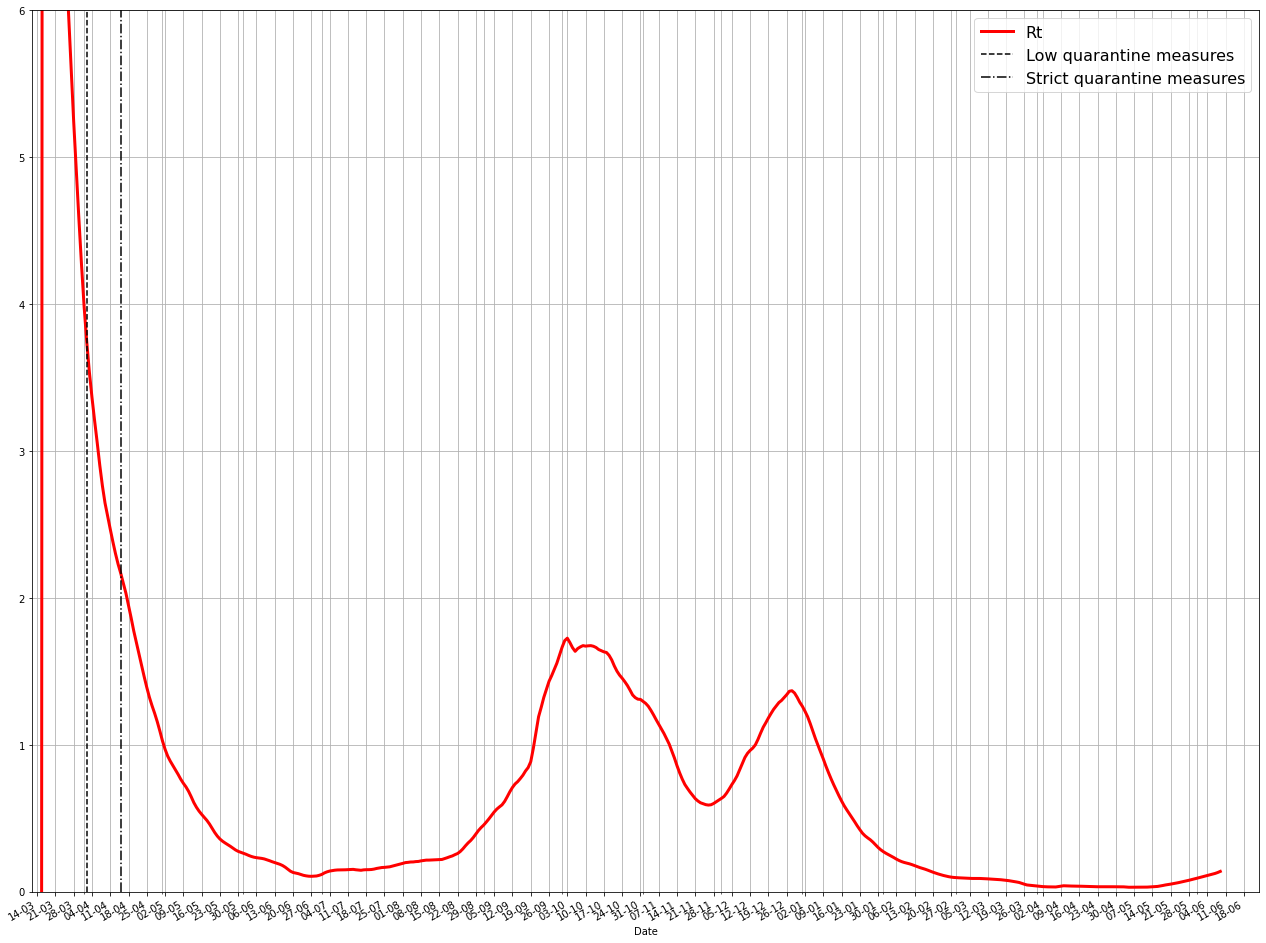

In [12]:
import matplotlib.dates as mdates
ax = df.plot('Date','Rt',linewidth=3,color='red',grid=True,ylim=(0,6),figsize=(22,18))
ax.axvline('2020-04-02', color='k', linestyle='--',label='Low quarantine measures') # change the qurantine dates 
ax.axvline('2020-04-15', color='k', linestyle='-.',label='Strict quarantine measures')# change the quarantine dates
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gcf().autofmt_xdate()
plt.legend(fontsize=16)

Population = 67886004.0, Infection start date (>100) = 2020-03-12


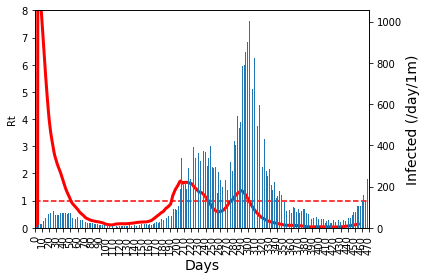

In [13]:
def plot(population,df,ax=None):
    n = 0 # get_start_index(df)
    start_date = df.iloc[n,0]
    if ax is None:
        print("Population = {}, Infection start date (>100) = {}".format(population,start_date.date()))
    df['Days'] = df['Date'].apply(lambda x : (x-start_date).days)
    df['PI'] = df['Infected'] / population * 100
    df['Delta_Infected_Gr'] = (df['Infected'].diff()).clip(lower=0) / population * 1000000
    ax = ax or plt.gca()
    ax = df.plot('Days','Rt',ax=ax,legend=False,linewidth=3,color='red')
    ax.axhline(y = 1,linestyle='--', color='red')
    ax.set_ylim(0,8)
    ax.set_ylabel('Rt')
    df.plot(x='Days',y='Delta_Infected_Gr',secondary_y=True,kind='bar',ax=ax,legend=False)#,xticks=df['Days'][::10])
    ax.set_xlabel('Days',fontsize=14)
    ax.set_xticks(df['Days'][::10])
    ax.set_xticklabels(df['Days'][::10])
    ax.right_ax.set_ylabel('Infected (/day/1m)',fontsize=14)
plot(pop,df)

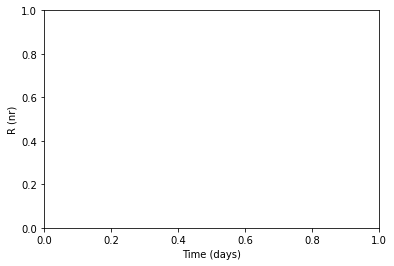

In [14]:
# England

R= np.linspace(0, 10, 100)
position=np.linspace(0, 8, 100)

R = (0.9, 1.0 ,1.0, 0.9, 0.9 ,0.9,1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.1, 1.0, 1.2, 1.4, 1.5, 1.6, 1.5, 1.4, 1.4, 1.3, 1.3, 1.2, 1.1, 1.0, 1.0, 1.0, 1.3, 1.4,1.4, 1.3, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.0, 1.1, 1.1, 1.1, 1.2, 1.4,1.4 )
position = (7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343)


plt.xlabel('Time (days)')
plt.ylabel('R (nr)')
trace1= go.Scatter(x= df['Days'] , 
                              y= df['Rt'],
                              name = "Estimated",
                              line = dict(color = 'Red'),
                              opacity = 0.8)
trace2= go.Scatter(x= position , 
                              y= R,
                              name = "Real",
                              line = dict(color = 'Green'),
                              opacity = 0.8)


data = [trace2, trace1]
layout = dict (title=' Covid-19 cases England')
#fig =   dict(data=data, layout=layout)
fig = go.Figure(data=data, layout=layout)
fig.show()



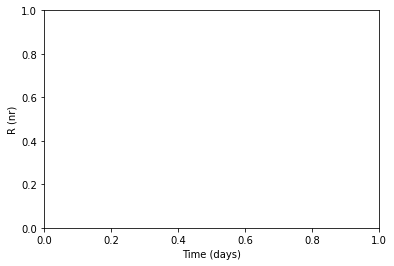

In [15]:

# Norway

R= np.linspace(0, 10, 18)
position=np.linspace(0, 8, 18)

R = [ 3.1, 0.5, 0.7,  0.7, 0.9, 1.2, 1.4, 0.8, 1.06,  0.6, 0.8, 1.5, 1.1, 0.79, 0.84, 1.1, 0.7]
position = (0, 30, 50, 70, 100, 120, 150, 180, 200, 230, 260, 280, 300, 330, 350, 380, 400 )


plt.xlabel('Time (days)')
plt.ylabel('R (nr)')
trace1= go.Scatter(x= df['Days'] , 
                              y= df['Rt'],
                              name = "Estimated",
                              line = dict(color = 'Red'),
                              opacity = 0.8)
trace2= go.Scatter(x= position , 
                              y= R,
                              name = "Real",
                              line = dict(color = 'Green'),
                              opacity = 0.8)


data = [trace2, trace1]
layout = dict (title=' Covid-19 cases Norway')
#fig =   dict(data=data, layout=layout)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
countries = [
    ['Spain','Italy', 'Germany', 'France'],
    ['Brazil', 'United Kingdom', 'US', 'Russia'],
    ['Sweden', 'Norway', 'Finland', 'Denmark'],        
    ['China', 'Japan', 'Korea, South', 'India']]

# Compute all countries
country_data = {}
for x in sum(countries,[]):
    print("Computing data for {}".format(x))
    country_data[x] = analyze(x)

Computing data for Spain


Producing a table of $R_0$ values for countries. It is as simple as taking the $R_t$ value at the index 0

In [ ]:
r0s = pd.DataFrame([ (c,k[1].iloc[0]['Rt']) for c,k in country_data.items() ],columns=['Country','R0'])
r0s

Plot for different countries 

In [ ]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('font',size=14)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_data[c]
        plot(pop,df,ax=ax[i,j])
        ax[i,j].set_xlim(0,450)
        ax[i,j].set_title(c,fontsize=20)
        ax[i,j].axes.xaxis.set_visible(True)
fig.tight_layout()
plt.show()

## Comparing $R_t$ Graphs



In [ ]:
rtdf = [
    cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items()]

In [ ]:
from functools import reduce
rtdf = reduce(lambda df,f : df.join(f), rtdf)

In [ ]:
#rtdf.tail(50)


In [ ]:
#rtdf.plot(figsize=(13,9))

It is impractival to see all graphs on one plot, so we plot only a few countries of interest.

In [ ]:
def plot_countries(l):
    rtdf = [cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items() if c in l]
    rtdf = reduce(lambda df,f : df.join(f), rtdf)
    rtdf.plot(figsize=(10,7))


plt.show()
plot_countries(['Sweden'])





In [ ]:

R= np.linspace(0, 10, 18)
position=np.linspace(0, 8, 18)

R = [ 3.1, 0.5, 0.7,  0.7, 0.9, 1.2, 1.4, 0.8, 1.06,  0.6, 0.8, 1.5, 1.1, 0.79, 0.84, 1.1, 0.7]
position = (0, 30, 50, 70, 100, 120, 150, 180, 200, 230, 260, 280, 300, 330, 350, 380, 400 )


plt.xlabel('Time (days)')
plt.ylabel('R (nr)')
trace1= go.Scatter(x= df['Days'] , 
                              y= df['Rt'],
                              name = "Estimated",
                              line = dict(color = 'Red'),
                              opacity = 0.8)
trace2= go.Scatter(x= position , 
                              y= R,
                              name = "Real",
                              line = dict(color = 'Green'),
                              opacity = 0.8)


data = [trace2, trace1]
layout = dict (title=' Covid-19 cases Norway')
#fig =   dict(data=data, layout=layout)
fig = go.Figure(data=data, layout=layout)
fig.show()


In [ ]:
def plot_countries(l):
    rtdf = [cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items() if c in l]
    rtdf = reduce(lambda df,f : df.join(f), rtdf)
    rtdf.plot(figsize=(10,7))

plot_countries(['China','India','','Korea'])